<a href="https://colab.research.google.com/github/prkokate/L3Cube/blob/main/Task_0/MarathiBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,pipeline,AutoTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
 !pip install transformers -U

In [3]:
 !pip install transformers[torch]

In [4]:
!pip install accelerate

In [5]:
train_data_path = '/content/tweets-train.csv'
valid_data_path = '/content/tweets-valid.csv'

In [6]:
train_df = pd.read_csv(train_data_path)
valid_df = pd.read_csv(valid_data_path)

In [7]:
train_df['label'] = train_df['label'].apply(lambda x: x + 1)  # Adjust labels to start from 0
valid_df['label'] = valid_df['label'].apply(lambda x: x + 1)

Adjust the labels to avoid IndexError while training (eliminate -1)

In [8]:
train_df.head()

,tweet,label
0,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे...,0
1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोल...,0
2,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिका...,0
3,आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्...,2
4,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म...,0


**L3Cube-pune: marathi-sentiment model Execution**

In [9]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/marathi-sentiment-md")
model = AutoModelForSequenceClassification.from_pretrained("l3cube-pune/marathi-sentiment-md")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [11]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
# model = model.to(device)

In [12]:
sample_data = ["सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोलिसांनी प्रा. आनंद तेलतुंबडेंना अटक केली मात्र न्यायालयाने त्यांची अटक बेकायदेशीर ठरवून सरकारला जोरदार चपराक लगावली आहे. कायदा हातात घेणा-या पोलीस अधिका-यांवर तात्काळ कारवाई केली पाहिजे"]
tokenizer(sample_data, padding=True, truncation=True, max_length=512)

{'input_ids': [[104, 8385, 120210, 12896, 50973, 98566, 3009, 45370, 10788, 121, 7663, 5907, 35968, 172894, 4281, 32544, 1917, 2282, 52709, 5538, 32544, 165948, 113601, 60897, 37751, 436, 84813, 1560, 88645, 2070, 1155, 121, 18301, 31932, 434, 5534, 1218, 120, 1165, 21343, 81203, 120, 91688, 182383, 45129, 1917, 15437, 105]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [13]:
X_train = list(train_df["tweet"])
y_train = list(train_df["label"])
X_val = list(valid_df["tweet"])
y_val = list(valid_df["label"])
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [14]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
print(X_train_tokenized['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
len(X_val),len(y_val)

(1500, 1500)

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [18]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [19]:
# batch_size = 32  # Ensure batch_size is consistent

# train_sampler = RandomSampler(train_dataset)
# train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# val_sampler = SequentialSampler(val_dataset)
# val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [20]:
len(train_dataset),len(val_dataset)

(12114, 1500)

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [10]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='macro')
    precision = precision_score(y_true=labels, y_pred=pred,average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred,average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [22]:
args = TrainingArguments(
    output_dir="output1",
    num_train_epochs=1,
    per_device_train_batch_size=18,
    per_device_eval_batch_size=18

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

Step,Training Loss
500,0.183000


Step,Training Loss
500,0.183000


TrainOutput(global_step=673, training_loss=0.17884868604821577, metrics={'train_runtime': 19213.0803, 'train_samples_per_second': 0.631, 'train_steps_per_second': 0.035, 'total_flos': 840416117613660.0, 'train_loss': 0.17884868604821577, 'epoch': 1.0})

In [52]:
trainer2 = Trainer(                       #Corrected compute_metrics function, re-evaluate using trained model
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [53]:
Evalres=trainer2.evaluate()
Evalres

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.6152633428573608,
 'eval_accuracy': 0.8553333333333333,
 'eval_precision': 0.855130566910499,
 'eval_recall': 0.8553333333333334,
 'eval_f1': 0.855162850954434,
 'eval_runtime': 509.2804,
 'eval_samples_per_second': 2.945,
 'eval_steps_per_second': 0.165}

In [56]:
stats=trainer.state.log_history
stats

[{'loss': 0.183,
  'grad_norm': 11.904847145080566,
  'learning_rate': 1.2852897473997027e-05,
  'epoch': 0.7429420505200595,
  'step': 500},
 {'train_runtime': 19213.0803,
  'train_samples_per_second': 0.631,
  'train_steps_per_second': 0.035,
  'total_flos': 840416117613660.0,
  'train_loss': 0.17884868604821577,
  'epoch': 1.0,
  'step': 673}]

In [47]:
trainer.save_model('Marathi-Bert-model')

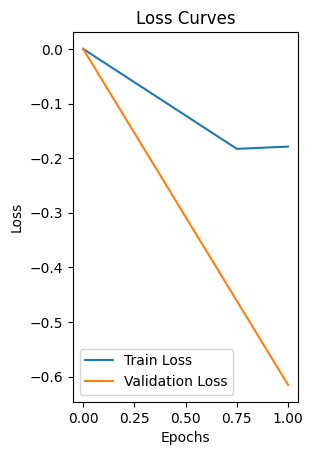

In [63]:
plt.subplot(1, 2, 2)
plt.plot([0,0.75,1], [0,-stats[0]['loss'],-stats[1]['train_loss']], label='Train Loss')
plt.plot([0,1],[0,-Evalres['eval_loss']], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# plt.savefig('E:/BE Project/Classify_Me/training_validation_curves.png')
plt.show()

In [64]:
trainerForTrainAcc = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    compute_metrics=compute_metrics
)

In [65]:
trainAcc=trainerForTrainAcc.evaluate()
trainAcc

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.05866897478699684,
 'eval_accuracy': 0.9860491992735678,
 'eval_precision': 0.986058729113991,
 'eval_recall': 0.9860491992735678,
 'eval_f1': 0.9860409100970496,
 'eval_runtime': 5400.784,
 'eval_samples_per_second': 2.243,
 'eval_steps_per_second': 0.125}

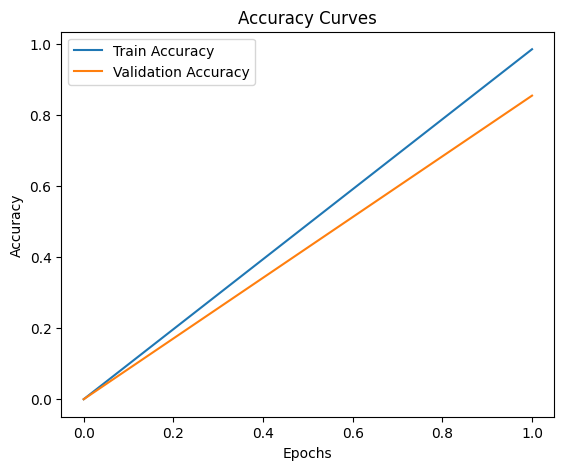

In [66]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([0,1], [0,trainAcc['eval_accuracy']], label='Train Accuracy')
plt.plot([0,1], [0,Evalres['eval_accuracy']], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

Testing out the model with pipeline

In [24]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="l3cube-pune/marathi-sentiment-md")

In [25]:
pipe("आज, बारामती शहर परिसरात सुरु असणाऱ्या विविध विकास कामांना प्रत्यक्ष भेटी देत कामाचा आढावा घेतला. शहरासह तालुक्यातील कायदा-सुव्यवस्था सुरळीत राखण्यासाठी अवैध व्यवसाय करणाऱ्यांवर कडक कारवाई करण्याचे निर्देश दिले.")

[{'label': 'Positive', 'score': 0.9865500926971436}]

In [26]:
train_df.head()

,tweet,label
0,ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे...,0
1,सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोल...,0
2,उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिका...,0
3,आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्...,2
4,बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म...,0


In [27]:
text_train= list(train_df['tweet'])
text_train[0]

'  ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे वृत्त   दु:खद आहे. चार दशकं त्यांनी आपल्या परखड लेखणीने पत्रकारितेत अमूल्य योगदान दिले. दीक्षित यांच्या मार्गदर्शनाखाली पत्रकारांची पिढी घडली. अनंत दीक्षित यांना भावपूर्ण श्रद्धांजली! \nआम्ही त्यांच्या परिवाराच्या दु:खात सहभागी आहोत. pic.twitter.com/s3gnQQLtpk\n'

In [67]:
# target_label= list(train_df['label'])
# label_mapping = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
# target_label= list(map(lambda x: label_mapping[x], target_label))
# target_label

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

**INDIC BERT EXECUTION START**

In [11]:
import torch.nn as nn

In [12]:
from transformers import AutoModel
# model = AutoModel.from_pretrained("ai4bharat/indic-bert")

In [13]:
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
base_model = AutoModel.from_pretrained("ai4bharat/indic-bert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [22]:
class IndicBERTForSequenceClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super(IndicBERTForSequenceClassification, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Use the pooled output for classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return (loss, logits) if loss is not None else logits

num_labels = 3  # For Positive, Negative, Neutral
base_model = IndicBERTForSequenceClassification(base_model, num_labels)

In [23]:
def tokenize_data(df, tokenizer):
    return tokenizer(
        df['tweet'].tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

In [24]:
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(valid_df, tokenizer)

In [25]:
train_labels = torch.tensor(train_df['label'].tolist())
val_labels = torch.tensor(valid_df['label'].tolist())

In [26]:
class IndicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = IndicDataset(train_encodings, train_labels)
val_dataset = IndicDataset(val_encodings, val_labels)

In [28]:
indicargs = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=18,
    per_device_eval_batch_size=18

)
base_trainer = Trainer(
    model=base_model,
    args=indicargs,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [29]:
base_trainer.train()

Step,Training Loss
500,0.885900


Step,Training Loss
500,0.885900


TrainOutput(global_step=673, training_loss=0.8259785554384229, metrics={'train_runtime': 17055.5969, 'train_samples_per_second': 0.71, 'train_steps_per_second': 0.039, 'total_flos': 0.0, 'train_loss': 0.8259785554384229, 'epoch': 1.0})

In [30]:
base_trainer.save_model('Indic-Bert-model')  #Saving the model

Importing the saved model

In [25]:
# base_model = AutoModel.from_pretrained("/content/",from_tf=False)

Some weights of AlbertModel were not initialized from the model checkpoint at /content/ and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.bias', 'encoder.albert_layer_groups.0.albert_layers.0.attention.LayerNorm.weight', 'encoder.albert_layer_groups.0.albert_layers.0.attention.dense.bias', 'encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight', 'encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias', 'encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight', 'encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias', 'encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight', 'encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias', 'encoder.albert_layer_groups.0.albert_layers.0.attention.valu

In [39]:
# base_trainer = Trainer(
#     model=base_model,
#     args=indicargs,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics
# )

Validation Stats for Indic Bert

In [31]:
val_results = base_trainer.evaluate()
print("Validation Results:", val_results)

<class 'transformers.trainer_utils.EvalPrediction'>
Validation Results: {'eval_loss': 0.6000871062278748, 'eval_accuracy': 0.742, 'eval_precision': 0.7395067417202558, 'eval_recall': 0.742, 'eval_f1': 0.7395629458803282, 'eval_runtime': 673.8646, 'eval_samples_per_second': 2.226, 'eval_steps_per_second': 0.125, 'epoch': 1.0}


Training stats for Indic Bert

In [35]:
train_results = base_trainer.evaluate(eval_dataset=train_dataset)
print("Train Results:", train_results)

<class 'transformers.trainer_utils.EvalPrediction'>
Train Results: {'eval_loss': 0.6018404364585876, 'eval_accuracy': 0.7447581310879974, 'eval_precision': 0.7429558169661883, 'eval_recall': 0.7447581310879974, 'eval_f1': 0.7423015845972749, 'eval_runtime': 5553.4175, 'eval_samples_per_second': 2.181, 'eval_steps_per_second': 0.121, 'epoch': 1.0}


In [32]:
base_stats=base_trainer.state.log_history
#base_stats=[{'train_runtime': 16670.6721, 'train_samples_per_second': 0.727, 'train_steps_per_second': 0.04, 'total_flos': 0.0, 'loss': 0.917054197586309, 'epoch': 1.0},{'train_runtime': 16670.6721, 'train_samples_per_second': 0.727, 'train_steps_per_second': 0.04, 'total_flos': 0.0, 'loss': 0.897054197586309, 'epoch': 1.0}]
#setting previously calculated values
base_stats

[{'loss': 0.8859,
  'grad_norm': 11.026805877685547,
  'learning_rate': 1.2852897473997027e-05,
  'epoch': 0.7429420505200595,
  'step': 500},
 {'train_runtime': 17055.5969,
  'train_samples_per_second': 0.71,
  'train_steps_per_second': 0.039,
  'total_flos': 0.0,
  'train_loss': 0.8259785554384229,
  'epoch': 1.0,
  'step': 673},
 {'eval_loss': 0.6000871062278748,
  'eval_accuracy': 0.742,
  'eval_precision': 0.7395067417202558,
  'eval_recall': 0.742,
  'eval_f1': 0.7395629458803282,
  'eval_runtime': 673.8646,
  'eval_samples_per_second': 2.226,
  'eval_steps_per_second': 0.125,
  'epoch': 1.0,
  'step': 673}]

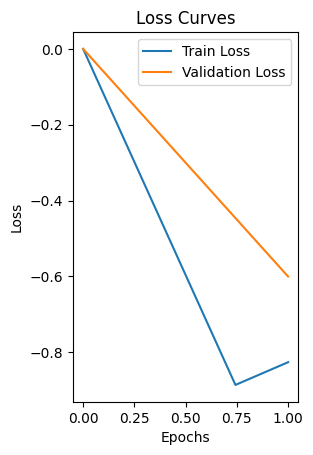

In [34]:
plt.subplot(1, 2, 2)
plt.plot([0,0.743,1], [0,-base_stats[0]['loss'],-base_stats[1]['train_loss']], label='Train Loss')
plt.plot([0,1],[0,-val_results['eval_loss']], label='Validation Loss') #Model need to be trained again
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# plt.savefig('E:/BE Project/Classify_Me/training_validation_curves.png')
plt.show()

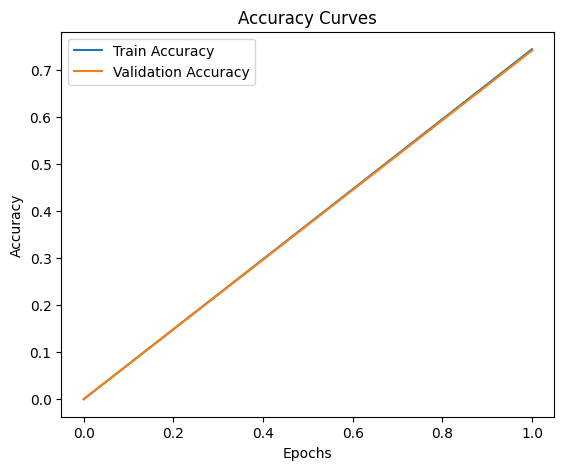

In [4]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot([0,1], [0,train_results['eval_accuracy']], label='Train Accuracy')
plt.plot([0,1], [0,val_results['eval_accuracy']], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()